In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES']="2"

In [3]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
    
def plot_history(history):
    losses1 = [x['val_loss1'] for x in history]
    losses2 = [x['val_loss2'] for x in history]
    plt.plot(losses1, '-x', label="loss1")
    plt.plot(losses2, '-x', label="loss2")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Losses vs. No. of epochs')
    plt.grid()
    plt.show()

In [4]:
import torch.nn as nn

device = get_default_device()

class Encoder(nn.Module):
    def __init__(self, in_size, latent_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, int(in_size/2))
        self.linear2 = nn.Linear(int(in_size/2), int(in_size/4))
        self.linear3 = nn.Linear(int(in_size/4), latent_size)
        self.relu = nn.ReLU(True)
        
    def forward(self, w):
        out = self.linear1(w)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.linear3(out)
        z = self.relu(out)
        return z
    
class Decoder(nn.Module):
    def __init__(self, latent_size, out_size):
        super().__init__()
        self.linear1 = nn.Linear(latent_size, int(out_size/4))
        self.linear2 = nn.Linear(int(out_size/4), int(out_size/2))
        self.linear3 = nn.Linear(int(out_size/2), out_size)
        self.relu = nn.ReLU(True)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, z):
        out = self.linear1(z)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.linear3(out)
        w = self.sigmoid(out)
        return w
    
class UsadModel(nn.Module):
    def __init__(self, w_size, z_size):
        super().__init__()
        self.encoder = Encoder(w_size, z_size)
        self.decoder1 = Decoder(z_size, w_size)
        self.decoder2 = Decoder(z_size, w_size)
  
    def training_step(self, batch, n):
        z = self.encoder(batch)
        w1 = self.decoder1(z)
        w2 = self.decoder2(z)
        w3 = self.decoder2(self.encoder(w1))
        loss1 = 1/n*torch.mean((batch-w1)**2)+(1-1/n)*torch.mean((batch-w3)**2)
        loss2 = 1/n*torch.mean((batch-w2)**2)-(1-1/n)*torch.mean((batch-w3)**2)
        return loss1,loss2

    def validation_step(self, batch, n):
        z = self.encoder(batch)
        w1 = self.decoder1(z)
        w2 = self.decoder2(z)
        w3 = self.decoder2(self.encoder(w1))
        loss1 = 1/n*torch.mean((batch-w1)**2)+(1-1/n)*torch.mean((batch-w3)**2)
        loss2 = 1/n*torch.mean((batch-w2)**2)-(1-1/n)*torch.mean((batch-w3)**2)
        return {'val_loss1': loss1, 'val_loss2': loss2}
        
    def validation_epoch_end(self, outputs):
        batch_losses1 = [x['val_loss1'] for x in outputs]
        epoch_loss1 = torch.stack(batch_losses1).mean()
        batch_losses2 = [x['val_loss2'] for x in outputs]
        epoch_loss2 = torch.stack(batch_losses2).mean()
        return {'val_loss1': epoch_loss1.item(), 'val_loss2': epoch_loss2.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss1: {:.4f}, val_loss2: {:.4f}".format(epoch, result['val_loss1'], result['val_loss2']))
    
def evaluate(model, val_loader, n):
    outputs = [model.validation_step(to_device(batch,device), n) for [batch] in val_loader]
    return model.validation_epoch_end(outputs)

def training(epochs, model, train_loader, val_loader, opt_func=torch.optim.AdamW):
    history = []
    optimizer1 = opt_func(list(model.encoder.parameters())+list(model.decoder1.parameters()))
    optimizer2 = opt_func(list(model.encoder.parameters())+list(model.decoder2.parameters()))
    for epoch in range(epochs):
        for [batch] in train_loader:
            batch=to_device(batch,device)
            
            #Train AE1
            loss1,loss2 = model.training_step(batch,epoch+1)
            loss1.backward()
            optimizer1.step()
            optimizer1.zero_grad()
            
            
            #Train AE2
            loss1,loss2 = model.training_step(batch,epoch+1)
            loss2.backward()
            optimizer2.step()
            optimizer2.zero_grad()
            
            
        result = evaluate(model, val_loader, epoch+1)
        model.epoch_end(epoch, result)
        history.append(result)
    return history
    
def testing(model, test_loader, alpha=.5, beta=.5):
    results=[]
    for [batch] in test_loader:
        batch=to_device(batch,device)
        w1=model.decoder1(model.encoder(batch))
        w2=model.decoder2(model.encoder(w1))
        results.append(alpha*torch.mean((batch-w1)**2,axis=1)+beta*torch.mean((batch-w2)**2,axis=1))
    return results

In [5]:
import sys

from pathlib import Path
from datetime import timedelta

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from TaPR_pkg import etapr
from tqdm import tqdm

In [6]:
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [7]:
TRAIN_DATASET = sorted([x for x in Path("./data/train/").glob("*.csv")])
TEST_DATASET = sorted([x for x in Path("./data/test/").glob("*.csv")])
VALIDATION_DATASET = sorted([x for x in Path("./data/validation/").glob("*.csv")])

In [8]:
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW.reset_index(drop=True,inplace=True)

TRAIN_DF_RAW_01 = dataframe_from_csv(TRAIN_DATASET[0])
TRAIN_DF_RAW_01.reset_index(drop=True,inplace=True)

TRAIN_DF_RAW_02 = dataframe_from_csv(TRAIN_DATASET[1])
TRAIN_DF_RAW_02.reset_index(drop=True,inplace=True)

TRAIN_DF_RAW_03 = dataframe_from_csv(TRAIN_DATASET[2])
TRAIN_DF_RAW_03.reset_index(drop=True,inplace=True)

TRAIN_DF_RAW_04 = dataframe_from_csv(TRAIN_DATASET[3])
TRAIN_DF_RAW_04.reset_index(drop=True,inplace=True)

TRAIN_DF_RAW_05 = dataframe_from_csv(TRAIN_DATASET[4])
TRAIN_DF_RAW_05.reset_index(drop=True,inplace=True)

TRAIN_DF_RAW_06 = dataframe_from_csv(TRAIN_DATASET[5])
TRAIN_DF_RAW_06.reset_index(drop=True,inplace=True)

print(TRAIN_DF_RAW.shape)
TRAIN_DF_RAW.head()

(1004402, 87)


,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,2021-07-11 10:00:00,-2.2642,0,12.26196,-0.00087,12.01019,0.2254,12.66931,70,1,...,0.92255,30.08042,7.08818,595.06104,276.40338,1,1014.79321,12.0,50,3506
1,2021-07-11 10:00:01,-2.4923,0,12.26196,0.00058,12.56714,-0.0711,12.66931,70,1,...,0.92255,30.08423,7.08818,531.50317,276.18634,1,1014.79321,12.0,50,3493
2,2021-07-11 10:00:02,-2.8460,0,12.26196,-0.00072,14.48975,0.0051,12.66931,70,1,...,0.91873,30.09148,7.08818,451.06253,279.85754,1,1014.79321,12.0,50,3490
3,2021-07-11 10:00:03,-2.1235,0,12.26196,0.00101,15.93170,0.1842,12.66931,70,1,...,0.91644,30.10407,7.08818,404.38739,281.50317,1,1014.79321,12.0,50,3525
4,2021-07-11 10:00:04,-2.9074,0,12.26196,0.00043,16.10718,0.1842,12.66931,70,1,...,0.91797,30.10331,7.08818,382.53925,281.34039,1,1014.79321,12.0,50,3503


변화가 없는 장치 목록

C22, C52, C63, C82, C85, C55, C36, C26, C49, C38, C39, C29, C18, C19, C09
범주형 데이터 형태인 장치 목록

C02, C07, C08, C09, C10, C17, C18, C19, C22, C26, C29, C34, C35, C36, C38, C39, C46, C48, C49, C52, C55, C58, C61, C63, C64, C69, C79, C82, C85
예측의 Loss 값이 튀는 경우를 없애주기 위해서 범주형 데이터의 경우 제외

In [9]:
TIMESTAMP_FIELD = "timestamp"
DROP_FIELD = ["C02", "C07", "C08", "C09", "C10", "C17", "C18", "C19", "C22", "C26", "C29", "C34", "C35", "C36", "C38", "C39", "C46", "C48", "C49", "C52", "C55", "C58", "C61", "C63", "C64", "C69", "C79", "C82", "C85"]
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW_01.columns.drop([TIMESTAMP_FIELD])
VALID_COLUMNS_IN_TRAIN_DATASET = VALID_COLUMNS_IN_TRAIN_DATASET.drop(DROP_FIELD)
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['C01', 'C03', 'C04', 'C05', 'C06', 'C11', 'C12', 'C13', 'C14', 'C15',
       'C16', 'C20', 'C21', 'C23', 'C24', 'C25', 'C27', 'C28', 'C30', 'C31',
       'C32', 'C33', 'C37', 'C40', 'C41', 'C42', 'C43', 'C44', 'C45', 'C47',
       'C50', 'C51', 'C53', 'C54', 'C56', 'C57', 'C59', 'C60', 'C62', 'C65',
       'C66', 'C67', 'C68', 'C70', 'C71', 'C72', 'C73', 'C74', 'C75', 'C76',
       'C77', 'C78', 'C80', 'C81', 'C83', 'C84', 'C86'],
      dtype='object')

In [10]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [11]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [12]:
TRAIN_DF_01 = normalize(TRAIN_DF_RAW_01[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF_02 = normalize(TRAIN_DF_RAW_02[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF_03 = normalize(TRAIN_DF_RAW_03[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF_04 = normalize(TRAIN_DF_RAW_04[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF_05 = normalize(TRAIN_DF_RAW_05[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF_06 = normalize(TRAIN_DF_RAW_06[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()

In [13]:
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [14]:
window_size=12

windows_normal_01 = TRAIN_DF_01.values[np.arange(window_size)[None, :] + np.arange(TRAIN_DF_01.shape[0]-window_size)[:, None]]
windows_normal_02 = TRAIN_DF_02.values[np.arange(window_size)[None, :] + np.arange(TRAIN_DF_02.shape[0]-window_size)[:, None]]
windows_normal_03 = TRAIN_DF_03.values[np.arange(window_size)[None, :] + np.arange(TRAIN_DF_03.shape[0]-window_size)[:, None]]
windows_normal_04 = TRAIN_DF_04.values[np.arange(window_size)[None, :] + np.arange(TRAIN_DF_04.shape[0]-window_size)[:, None]]
windows_normal_05 = TRAIN_DF_05.values[np.arange(window_size)[None, :] + np.arange(TRAIN_DF_05.shape[0]-window_size)[:, None]]
windows_normal_06 = TRAIN_DF_06.values[np.arange(window_size)[None, :] + np.arange(TRAIN_DF_06.shape[0]-window_size)[:, None]]

In [15]:
import torch.utils.data as data_utils

BATCH_SIZE =  7919
N_EPOCHS = 100
hidden_size = 100

w_size=windows_normal_01.shape[1]*windows_normal_01.shape[2]
z_size=windows_normal_01.shape[1]*hidden_size

train_loader_01 = data_utils.TensorDataset(torch.from_numpy(windows_normal_01).float().view(([windows_normal_01.shape[0],w_size])))
train_loader_02 = data_utils.TensorDataset(torch.from_numpy(windows_normal_02).float().view(([windows_normal_02.shape[0],w_size])))
train_loader_03 = data_utils.TensorDataset(torch.from_numpy(windows_normal_03).float().view(([windows_normal_03.shape[0],w_size])))
train_loader_04 = data_utils.TensorDataset(torch.from_numpy(windows_normal_04).float().view(([windows_normal_04.shape[0],w_size])))
train_loader_05 = data_utils.TensorDataset(torch.from_numpy(windows_normal_05).float().view(([windows_normal_05.shape[0],w_size])))

val_loader_01 = data_utils.TensorDataset(torch.from_numpy(windows_normal_06).float().view(([windows_normal_06.shape[0],w_size])))

train_loader = torch.utils.data.DataLoader(data_utils.ConcatDataset(
    [train_loader_01, train_loader_02, train_loader_03, train_loader_04, train_loader_05]
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(val_loader_01, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [16]:
model = UsadModel(w_size, z_size)
model = to_device(model,device)

In [17]:
history = training(N_EPOCHS,model,train_loader,val_loader)

Epoch [0], val_loss1: 0.0269, val_loss2: 0.0284
Epoch [1], val_loss1: 0.0266, val_loss2: -0.0004
Epoch [2], val_loss1: 0.0253, val_loss2: -0.0086
Epoch [3], val_loss1: 0.0366, val_loss2: -0.0189
Epoch [4], val_loss1: 0.0349, val_loss2: -0.0221
Epoch [5], val_loss1: 0.0328, val_loss2: -0.0233
Epoch [6], val_loss1: 0.0361, val_loss2: -0.0276
Epoch [7], val_loss1: 0.0350, val_loss2: -0.0280
Epoch [8], val_loss1: 0.0500, val_loss2: -0.0398
Epoch [9], val_loss1: 0.0583, val_loss2: -0.0473
Epoch [10], val_loss1: 0.0349, val_loss2: -0.0274
Epoch [11], val_loss1: 0.0617, val_loss2: -0.0525
Epoch [12], val_loss1: 0.0482, val_loss2: -0.0409
Epoch [13], val_loss1: 0.0446, val_loss2: -0.0382
Epoch [14], val_loss1: 0.0436, val_loss2: -0.0377
Epoch [15], val_loss1: 0.0433, val_loss2: -0.0378
Epoch [16], val_loss1: 0.0432, val_loss2: -0.0380
Epoch [17], val_loss1: 0.0433, val_loss2: -0.0384
Epoch [18], val_loss1: 0.0433, val_loss2: -0.0387
Epoch [19], val_loss1: 0.0434, val_loss2: -0.0390
Epoch [20],

In [18]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "./models/usad.pth")

In [19]:
checkpoint = torch.load("./models/usad.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

In [20]:
VALIDATION_DF_RAW = dataframe_from_csv(VALIDATION_DATASET[0])
VALIDATION_DF_RAW.reset_index(drop=True,inplace=True)

In [21]:
VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()

다양한 모델을 사용하였습니다만, Train Set을 기준으로 Min-Max Normalize를 진행한 뒤, Validation Set과 Test Set에 대해 Train Dataset의 Min값 혹은 Max값을 넘어가는 값에 x2, x1.5를 해주었을 경우 성능이 소폭 향상되는 모습을 보여주었습니다.

Min-Max Normalization이 어느정도 Anomaly Detection에서 효과를 보여준다는 걸 보여주는 것으로도 볼 수 있고, 값이 튀는 장치들에 실제로도 보안위협이 들어왔다고 생각할 수도 있을 것 같습니다.

In [22]:
for i in tqdm(range(VALIDATION_DF.shape[0])):
    for j in range(VALIDATION_DF.shape[1]):
        if VALIDATION_DF.iloc[i, j] < 0:
            VALIDATION_DF.iloc[i, j] = VALIDATION_DF.iloc[i, j] * 2
        elif VALIDATION_DF.iloc[i, j] > 1:
            VALIDATION_DF.iloc[i, j] = VALIDATION_DF.iloc[i, j] * 2

100%|██████████| 86400/86400 [03:20<00:00, 430.61it/s]


In [23]:
val = VALIDATION_DF.values[np.arange(window_size)[None, :] + np.arange(VALIDATION_DF.shape[0]-window_size)[:, None]]

In [24]:
test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(val).float().view(([val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [25]:
results = testing(model,test_loader)

In [26]:
labels = [int(label!= 0 ) for label in VALIDATION_DF_RAW["attack"].values]

In [27]:
y_pred = np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

In [28]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = np.max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * np.array(peak) * np.array(0.3))
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

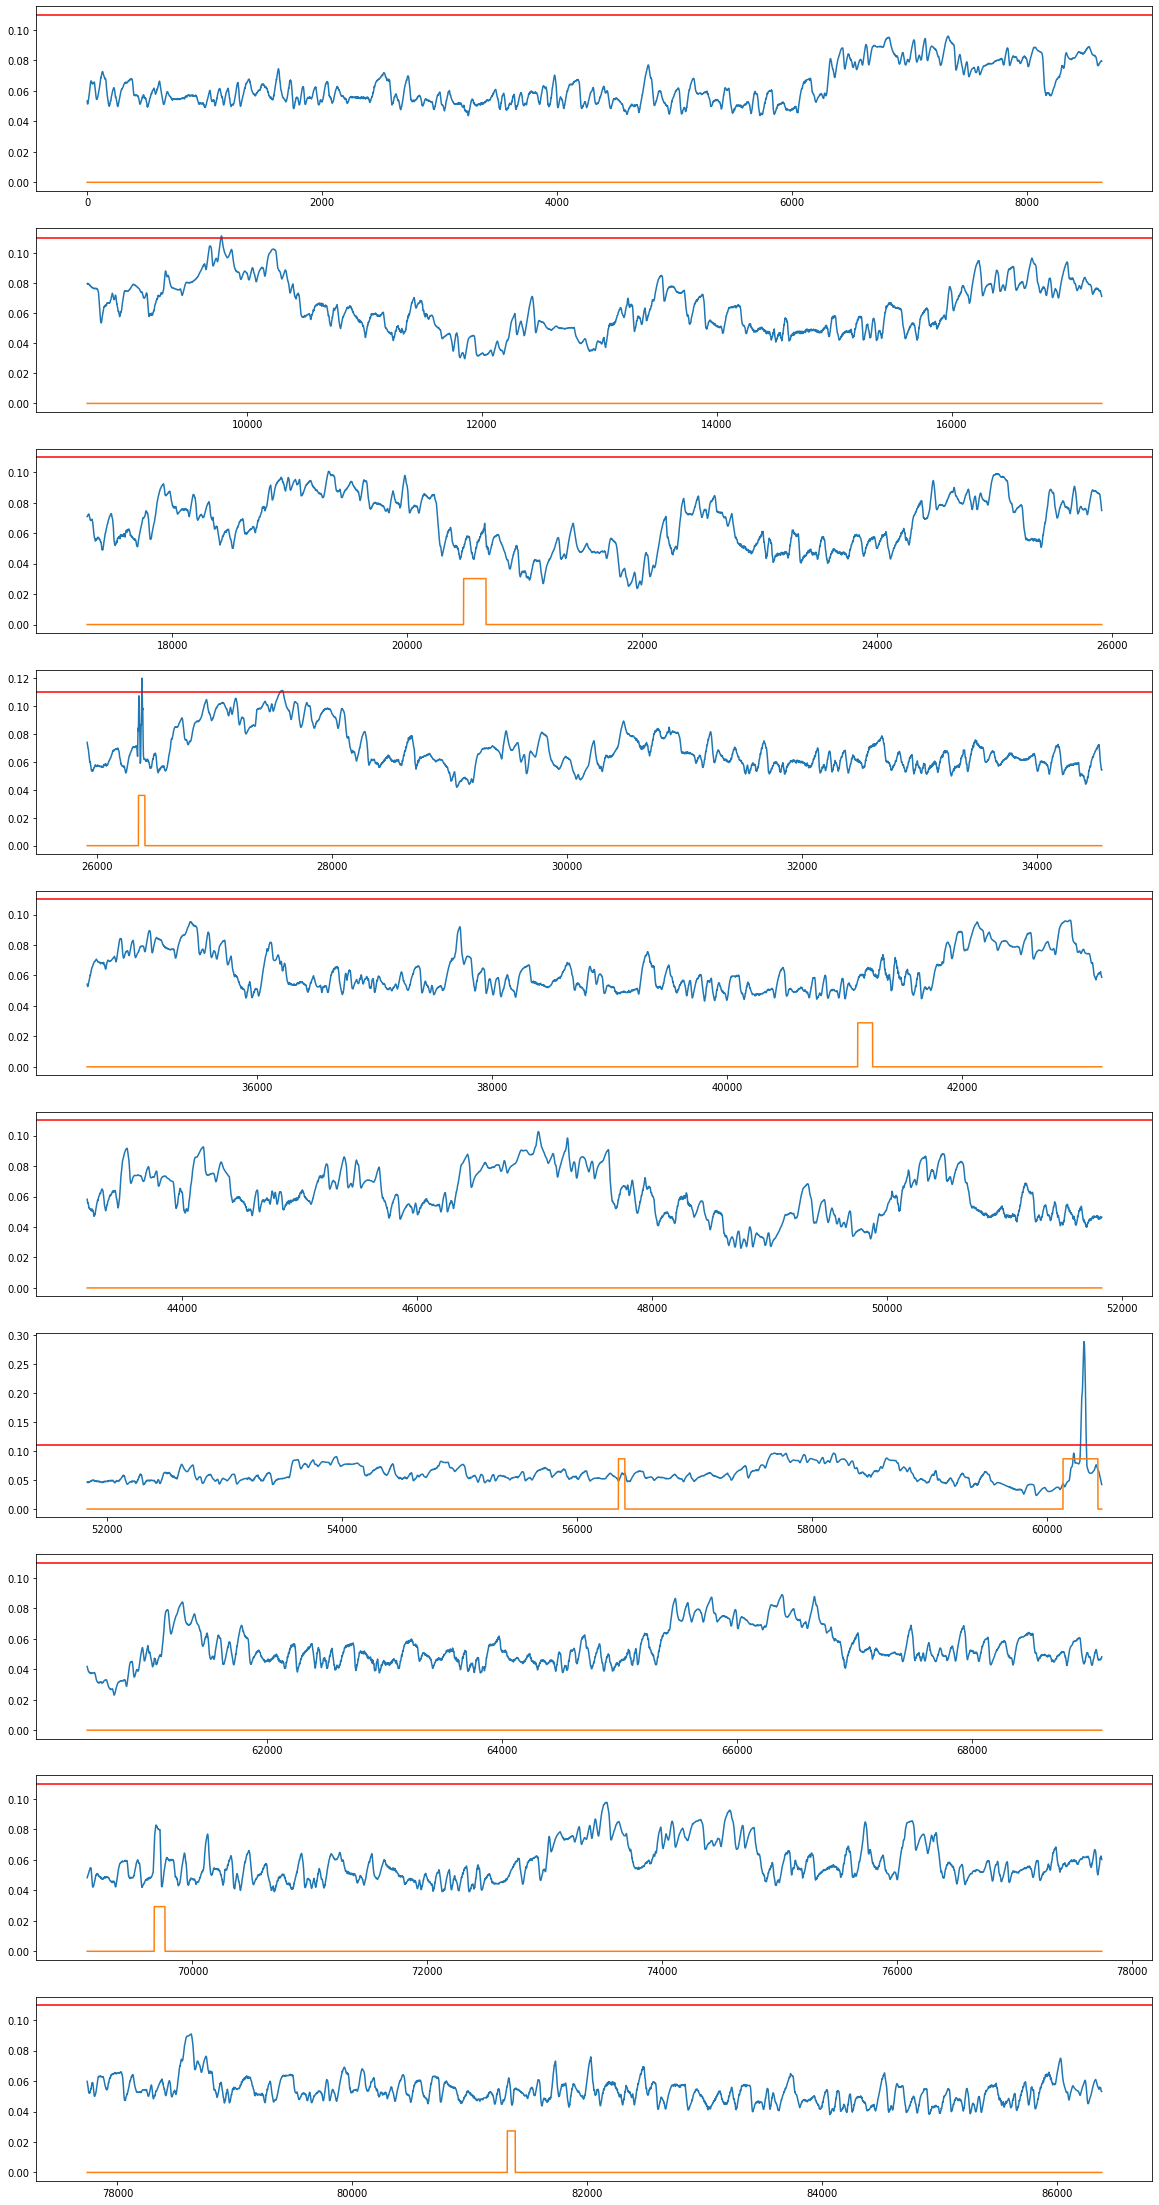

In [29]:
THRESHOLD = 0.11
check_graph(y_pred, labels, piece=10, THRESHOLD=THRESHOLD)

In [30]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

In [31]:
LABELS = put_labels(y_pred, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), (86388,))

In [32]:
a = np.zeros(window_size)
LABELS = np.append(a, LABELS, axis=0)

In [33]:
TaPR = etapr.evaluate_haicon(anomalies=labels, predictions=LABELS)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.078 (TaP: 0.129, TaR: 0.055)
# of detected anomalies: 1
Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x7fc943f1f9e8>]
